<ipython-input-14-560c943f1186>:42: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  a = log(1+0.5*npop)
<ipython-input-14-560c943f1186>:43: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  utilities = array([max(0, a-log(k)) for k in range(1,npop+1)])
<ipython-input-14-560c943f1186>:43: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  utilities = array([max(0, a-log(k)) for k in range(1,npop+1)])
<ipython-input-14-560c943f1186>:44: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  utilities /= sum(utilities)
<ipython-input-14-560c943f1186>:78: DeprecationWarning: scipy.eye is deprecated and will be removed in SciPy 2.0.0, use numpy.eye instead
  eyemat = eye(dim)
<ipython-input-14-560c943f1186>:83: DeprecationWarning: scipy.randn is deprecate

[]
Current: (-0.0002651659263218978,-0.0014529632447371206)
Exact solution is (0,0)
Took 0.2848987579345703 secs


<ipython-input-14-560c943f1186>:196: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


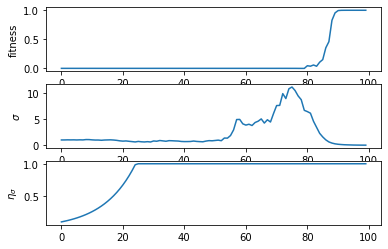

In [14]:
"""
xNES from 'Natural Evolution Strategies'
if n_jobs>1, I suggest using "export MKL_NUM_THREADS=1"
See at the bottom (under __main__) for an example of usage
"""
import joblib
import random
import numpy as np

import scipy as sp
from scipy import (dot, eye, randn, asarray, array, trace, log, exp, sqrt, mean, sum, argsort, square, arange)
from scipy.stats import multivariate_normal, norm
from scipy.linalg import (det, expm)

class XNES(object):
    def __init__(self, f, mu, amat,
                 eta_mu=1.0, eta_sigma=None, eta_bmat=None,
                 npop=None, use_fshape=True, use_adasam=False, patience=100, n_jobs=1):
        self.f = f
        self.mu = mu
        self.eta_mu = eta_mu
        self.use_adasam = use_adasam
        self.n_jobs = n_jobs

        dim = len(mu)
        sigma = abs(det(amat))**(1.0/dim)
        bmat = amat*(1.0/sigma)
        self.dim = dim
        self.sigma = sigma
        self.bmat = bmat

        # default population size and learning rates
        npop = int(4 + 3*log(dim)) if npop is None else npop
        eta_sigma = 3*(3+log(dim))*(1.0/(5*dim*sqrt(dim))) if eta_sigma is None else eta_sigma
        eta_bmat = 3*(3+log(dim))*(1.0/(5*dim*sqrt(dim))) if eta_bmat is None else eta_bmat
        self.npop = npop
        self.eta_sigma = eta_sigma
        self.eta_bmat = eta_bmat

        # compute utilities if using fitness shaping
        if use_fshape:
            a = log(1+0.5*npop)
            utilities = array([max(0, a-log(k)) for k in range(1,npop+1)])
            utilities /= sum(utilities)
            utilities -= 1.0/npop           # broadcast
            utilities = utilities[::-1]  # ascending order
        else:
            utilities = None
        self.use_fshape = use_fshape
        self.utilities = utilities

        # stuff for adasam
        self.eta_sigma_init = eta_sigma
        self.sigma_old = None

        # logging
        self.fitness_best = 100000000
        self.mu_best = None
        self.done = False
        self.counter = 0
        self.patience = patience
        self.history = {'eta_sigma':[], 'sigma':[], 'fitness':[]}

        # do not use these when hill-climbing
        if npop == 1:
            self.use_fshape = False
            self.use_adasam = False

    def step(self, niter):
        """ xNES """
        f = self.f
        mu, sigma, bmat = self.mu, self.sigma, self.bmat
        eta_mu, eta_sigma, eta_bmat = self.eta_mu, self.eta_sigma, self.eta_bmat
        npop = self.npop
        dim = self.dim
        sigma_old = self.sigma_old

        eyemat = eye(dim)

        with joblib.Parallel(n_jobs=self.n_jobs) as parallel:

            for i in range(niter):
                s_try = randn(npop, dim)
                z_try = mu + sigma * dot(s_try, bmat)     # broadcast

                f_try = parallel(joblib.delayed(f)(z) for z in z_try)
                f_try = asarray(f_try)

                # save if best
                fitness = mean(f_try)
                if fitness - 1e-8 > self.fitness_best:
                    self.fitness_best = fitness
                    self.mu_best = mu.copy()
                    self.counter = 0
                else: self.counter += 1
                if self.counter > self.patience:
                    self.done = True
                    return

                isort = argsort(f_try)
                f_try = f_try[isort]
                s_try = s_try[isort]
                z_try = z_try[isort]

                u_try = self.utilities if self.use_fshape else f_try

                if self.use_adasam and sigma_old is not None:  # sigma_old must be available
                    eta_sigma = self.adasam(eta_sigma, mu, sigma, bmat, sigma_old, z_try)

                dj_delta = dot(u_try, s_try)
                dj_mmat = dot(s_try.T, s_try*u_try.reshape(npop,1)) - sum(u_try)*eyemat
                dj_sigma = trace(dj_mmat)*(1.0/dim)
                dj_bmat = dj_mmat - dj_sigma*eyemat

                sigma_old = sigma

                # update
                mu += eta_mu * sigma * dot(bmat, dj_delta)
                sigma *= exp(0.5 * eta_sigma * dj_sigma)
                bmat = dot(bmat, expm(0.5 * eta_bmat * dj_bmat))

                # logging
                self.history['fitness'].append(fitness)
                self.history['sigma'].append(sigma)
                self.history['eta_sigma'].append(eta_sigma)

        # keep last results
        self.mu, self.sigma, self.bmat = mu, sigma, bmat
        self.eta_sigma = eta_sigma
        self.sigma_old = sigma_old

    def adasam(self, eta_sigma, mu, sigma, bmat, sigma_old, z_try):
        """ Adaptation sampling """
        eta_sigma_init = self.eta_sigma_init
        dim = self.dim
        c = .1
        rho = 0.5 - 1./(3*(dim+1))  # empirical

        bbmat = dot(bmat.T, bmat)
        cov = sigma**2 * bbmat
        sigma_ = sigma * sqrt(sigma*(1./sigma_old))  # increase by 1.5
        cov_ = sigma_**2 * bbmat

        p0 = multivariate_normal.logpdf(z_try, mean=mu, cov=cov)
        p1 = multivariate_normal.logpdf(z_try, mean=mu, cov=cov_)
        w = exp(p1-p0)

        # Mann-Whitney. It is assumed z_try was in ascending order.
        n = self.npop
        n_ = sum(w)
        u_ = sum(w * (np.arange(n)+0.5))

        u_mu = n*n_*0.5
        u_sigma = sqrt(n*n_*(n+n_+1)/12.)
        cum = norm.cdf(u_, loc=u_mu, scale=u_sigma)

        if cum < rho:
            return (1-c)*eta_sigma + c*eta_sigma_init
        else:
            return min(1, (1+c)*eta_sigma)


if __name__ == '__main__':
    ''' Example of usage code '''
    
    import time
    np.random.seed(42)
    random.seed(42)

    def f(x):                   # sin(x^2+y^2)/(x^2+y^2)
        r = sum(square(x))
        return sp.sin(r)/r

    mu = np.random.randint(-100,100,2).astype(float)  # a bad init guess
    amat = np.eye(2)

    # when adasam, use conservative eta
    xnes = XNES(f, mu, amat, npop=50, use_adasam=True, eta_bmat=0.01, eta_sigma=.1, patience=9999)
    t0 = time.time()
    print(xnes.history['fitness'])
    for i in range(1):
        xnes.step(100)
        print("Current: ({},{})".format(*xnes.mu))

    print("Exact solution is (0,0)")
    print("Took {} secs".format(time.time()-t0))

    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(3,1)
    axs[0].plot(xnes.history['fitness'])
    axs[1].plot(xnes.history['sigma'])
    axs[2].plot(xnes.history['eta_sigma'])
    axs[0].set_ylabel('fitness')
    axs[1].set_ylabel(r'$\sigma$')
    axs[2].set_ylabel(r'$\eta_{\sigma}$')
    fig.show()


In [19]:
from __future__ import print_function

__author__ = 'Tom Schaul, Sun Yi, Tobias Glasmachers'

from pybrain.tools.rankingfunctions import HansenRanking
from pybrain.optimization.distributionbased.distributionbased import DistributionBasedOptimizer
from pybrain.auxiliary.importancemixing import importanceMixing
from scipy.linalg import expm
from scipy import dot, array, randn, eye, outer, exp, trace, floor, log, sqrt


class XNES(DistributionBasedOptimizer):
    """ NES with exponential parameter representation. """

    # parameters, which can be set but have a good (adapted) default value
    covLearningRate = None
    centerLearningRate = 1.0
    scaleLearningRate = None
    uniformBaseline = True
    batchSize = None
    shapingFunction = HansenRanking()
    importanceMixing = False
    forcedRefresh = 0.01

    # fixed settings
    mustMaximize = True
    storeAllEvaluations = True
    storeAllEvaluated = True
    storeAllDistributions = False

    def _additionalInit(self):
        # good heuristic default parameter settings
        dim = self.numParameters
        if self.covLearningRate is None:
            self.covLearningRate = 0.6*(3+log(dim))/dim/sqrt(dim)
        if self.scaleLearningRate is None:
            self.scaleLearningRate = self.covLearningRate
        if self.batchSize is None:
            if self.importanceMixing:
                self.batchSize = 10*dim
            else:
                self.batchSize = 4+int(floor(3*log(dim)))

        # some bookkeeping variables
        self._center = self._initEvaluable.copy()
        self._A = eye(self.numParameters) # square root of covariance matrix
        self._invA = eye(self.numParameters)
        self._logDetA = 0.
        self._allPointers = []
        self._allGenSteps = [0]
        if self.storeAllDistributions:
            self._allDistributions = [(self._center.copy(), self._A.copy())]

    def _learnStep(self):
        """ Main part of the algorithm. """
        I = eye(self.numParameters)
        self._produceSamples()
        utilities = self.shapingFunction(self._currentEvaluations)
        utilities /= sum(utilities)  # make the utilities sum to 1
        if self.uniformBaseline:
            utilities -= 1./self.batchSize
        samples = array(list(map(self._base2sample, self._population)))

        dCenter = dot(samples.T, utilities)
        covGradient = dot(array([outer(s,s) - I for s in samples]).T, utilities)
        covTrace = trace(covGradient)
        covGradient -= covTrace/self.numParameters * I
        dA = 0.5 * (self.scaleLearningRate * covTrace/self.numParameters * I
                    +self.covLearningRate * covGradient)

        self._lastLogDetA = self._logDetA
        self._lastInvA = self._invA

        self._center += self.centerLearningRate * dot(self._A, dCenter)
        self._A = dot(self._A, expm(dA))
        self._invA = dot(expm(-dA), self._invA)
        self._logDetA += 0.5 * self.scaleLearningRate * covTrace
        if self.storeAllDistributions:
            self._allDistributions.append((self._center.copy(), self._A.copy()))

    @property
    def _lastA(self): return self._allDistributions[-2][1]
    @property
    def _lastCenter(self): return self._allDistributions[-2][0]
    @property
    def _population(self):
        if self._wasUnwrapped:
            return [self._allEvaluated[i].params for i in self._pointers]
        else:
            return [self._allEvaluated[i] for i in self._pointers]

    @property
    def _currentEvaluations(self):
        fits = [self._allEvaluations[i] for i in self._pointers]
        if self._wasOpposed:
            fits = [-x for x in fits]
        return fits

    def _produceSample(self):
        return randn(self.numParameters)

    def _sample2base(self, sample):
        """ How does a sample look in the outside (base problem) coordinate system? """
        return dot(self._A, sample)+self._center

    def _base2oldsample(self, e):
        """ How would the point have looked in the previous reference coordinates? """
        return dot(self._lastInvA, (e - self._lastCenter))

    def _base2sample(self, e):
        """ How does the point look in the present one reference coordinates? """
        return dot(self._invA, (e - self._center))

    def _oldpdf(self, s):
        s = self._base2oldsample(self._sample2base(s))
        return exp(-0.5*dot(s,s)- self._lastLogDetA)

    def _newpdf(self, s):
        return exp(-0.5*dot(s,s)- self._logDetA)

    def _produceSamples(self):
        """ Append batch size new samples and evaluate them. """
        reuseindices = []
        if self.numLearningSteps == 0 or not self.importanceMixing:
            [self._oneEvaluation(self._sample2base(self._produceSample())) for _ in range(self.batchSize)]
            self._pointers = list(range(len(self._allEvaluated)-self.batchSize, len(self._allEvaluated)))
        else:
            reuseindices, newpoints = importanceMixing(list(map(self._base2sample, self._currentEvaluations)),
                                                       self._oldpdf, self._newpdf, self._produceSample, self.forcedRefresh)
            [self._oneEvaluation(self._sample2base(s)) for s in newpoints]
            self._pointers = ([self._pointers[i] for i in reuseindices]+
                              list(range(len(self._allEvaluated)-self.batchSize+len(reuseindices), len(self._allEvaluated))))
        self._allGenSteps.append(self._allGenSteps[-1]+self.batchSize-len(reuseindices))
        self._allPointers.append(self._pointers)



if __name__ == '__main__':
    from pybrain.rl.environments.functions.unimodal import RosenbrockFunction
    from scipy import ones
    dim = 10
    f = RosenbrockFunction(dim)
    l = XNES(f, -ones(dim))
    print((l.learn()))
    print(('Evaluations needed:', len(l._allEvaluations)))

SyntaxError: invalid syntax (utilities.py, line 52)